<a href="https://colab.research.google.com/github/Surihub/Recommender-system/blob/main/TIMSS_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TIMSS recommender system
- 알고리즘 설정 : 두 가지만
- 함수 설정
- 정오답 예측 결과
- 추천 결과
- 추천의 정확도 결과

## 예측 및 예측 결과 정리

In [1]:
import time
import math 
import random 
import datetime 
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from google.colab import drive

# 데이터 불러오기
drive.mount("/content/gdrive/")
path = "/content/gdrive/MyDrive/2023석사논문코드/"
iteminfo = pd.read_csv(path+"iteminfo_ME10_ME11.csv")
timss19 = pd.read_csv(path+"df_RFS_ME10_ME11.csv", index_col=0).drop(labels = ['IDCNTRY',"IDSTUD"], axis = 1)
display(iteminfo.head(3))
print(iteminfo.shape)
display(timss19.head(3))
print(timss19.shape)

Mounted at /content/gdrive/


,Unnamed: 0,Block,Block_seq,Content_Domain,Topic_Area,Cognitive_Domain,Item_Type,Label,correct_per1,correct_per2,Item_ID
0,ME72187,ME10,1,Number,Integers,Knowing,CR,Sum of two numbers with exponents,0.556271,0.566869,ME72187
1,ME62271,ME11,1,Number,Fractions and Decimals,Knowing,MC,Randy's blue balloons,0.504519,0.510844,ME62271
2,ME72022,ME10,2,Number,Fractions and Decimals,Reasoning,MC,Value of P x Q on number line,0.395196,0.402929,ME72022


(28, 11)


,ME72187,ME72022,ME72045,ME72049,ME72069,ME72074,ME72013,ME72095,ME72109,ME72125,...,ME62230_F,ME62095_F,ME62076_F,ME62030_F,ME62171_F,ME62301_F,ME62194_F,ME62344_F,ME62320_F,ME62296_F
784_50010216,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,2.0,2.0,3.0,3.0,2.0,3.0,6.0,3.0,3.0,2.0
784_50010314,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,2.0
784_50030104,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0


(8077, 84)


In [2]:
## input data : timss19(pd.DataFrame 형태)
Utility_mat_total = timss19

# n_item : 문항정보표에서 가져오기
n_item = len(iteminfo)

# item_list : ME00000, 문항
item_list = Utility_mat_total.columns[n_item * 0 :n_item * 1] # 전체 아이템 리스트

# time_list : ME00000_S, 문항에 소요된 시간
time_list = Utility_mat_total.columns[n_item * 1 :n_item * 2] # 아이템_S

# freq_list : ME00000_F, 문항 클릭 빈도수
freq_list = Utility_mat_total.columns[n_item * 2 :n_item * 3] # 아이템_F

# response only
U_R = Utility_mat_total[item_list]+1

# sptime only
U_S = Utility_mat_total[time_list]

# frequency only
U_F = Utility_mat_total[freq_list]

# user item matrix를 row matrix로 변환(역 pivot) 함수
def ui_to_row(df):
  temp = df.copy()
  temp["IDSTUD"] = temp.index
  df_row = pd.melt(temp, id_vars = "IDSTUD", var_name = 'Item_ID', value_name = 'value')
  # na 제거
  df_row = df_row.dropna()
  df_row['Item_ID'] = df_row['Item_ID'].apply(lambda x: x[:7])
  return df_row

# display(ui_to_row(U_R).head(3))
# display(ui_to_row(U_S).head(3))
# display(ui_to_row(U_F).head(3))

def train_test_split(df, target_item, target_user):
  temp = ui_to_row(df)
  temp = temp[temp['Item_ID'].isin(target_item)]
  test = temp[temp['IDSTUD'].isin(target_user)]
  train = ui_to_row(df)[~ui_to_row(df).isin(temp)].dropna()
  return train, test

train , test = train_test_split(U_R, item_list[20:], U_R.index[-10:])


In [3]:
!pip install scikit-surprise
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise import Dataset, BaselineOnly, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3193677 sha256=12d7da5c509ac01884f5516bd2e0f7f23edad713a82f212e07f762edd08edc20
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [4]:
# # target 정하기
# Utility_mat = U_R.sample(frac=1, replace = False, random_state = 42)
# target_item = item_list[12:]
# target_user = Utility_mat.index.tolist()[-100:]#random.sample(Utility_mat.index.to_list(), int(len(Utility_mat.index)*0.2)) # int(len(Utility_mat.index)*0.2) = 1615 (약 20%)

In [5]:
# 실험할 알고리즘 설정하기 
algo_KNN_UBCF = KNNBasic(k=70, sim_options = {'name':'msd', 'user_based':True})
algo_KNNB_IBCF = KNNBaseline(k=5, sim_options = {'name':'msd', 'user_based':False})
algo_SVDpp = SVDpp(n_factors=8)

algo_list = [NormalPredictor(), BaselineOnly(), #대조군 
             algo_KNN_UBCF, algo_KNNB_IBCF, algo_SVDpp]#실험군
algo_list_str = ["NOR","BAS","KNN_U","KNNB_I","SVDpp"]

In [6]:
########## 함수로 만들기 1개씩 return
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import train_test_split

data = Dataset.load_from_df(ui_to_row(U_R), reader = Reader(rating_scale=(1,2)))
trainset, testset = train_test_split(data, test_size=0.25)

def surprise_predict(algo):
  algo.fit(trainset)
  predictions = algo.test(testset)
  predictions_df = pd.DataFrame(predictions)
  tr = np.array(predictions_df["r_ui"])
  pr = np.array(predictions_df["est"])
  pr_round = np.round(pr, 0)
  cm = confusion_matrix(tr, pr_round) #[[TN, FP],[FN, TP]]
  metric_dict = dict(confusion_mat = confusion_matrix(tr, pr_round), 
                              precision = precision_score(tr, pr_round), 
                              recall = recall_score(tr, pr_round), 
                              f1 = f1_score(tr, pr_round),
                              ACC = (cm[0][0]+cm[1][1])/cm.sum(),
                              AUC = roc_auc_score(tr, pr),
                              RMSE = accuracy.rmse(predictions, verbose=False))
  metric_dict = pd.DataFrame(metric_dict.values(),metric_dict.keys()).T
  new_index = []
  #알고리즘 이름만 따와서 인덱스로 만들기 
  metric_dict.index = ["{}".format(algo)]
  new_index.append(metric_dict.index[0].split(" ")[0].split(".")[-1])
  metric_dict.index = new_index
  ####################
  return metric_dict, predictions_df

algo = SVD()
metric_dict, predictions_df = surprise_predict(algo)


/usr/local/lib/python3.9/dist-packages/pandas/core/internals/construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


In [7]:
# 실험할 알고리즘 설정하기 
algo_KNN_UBCF = KNNBasic(k=70, sim_options = {'name':'msd', 'user_based':True})
algo_KNNB_IBCF = KNNBaseline(k=5, sim_options = {'name':'msd', 'user_based':False})
algo_SVDpp = SVDpp(n_factors=8)

algo_list = [NormalPredictor(), BaselineOnly(), #대조군 
             algo_KNN_UBCF, algo_KNNB_IBCF, algo_SVDpp]#실험군
algo_list_3 = [BaselineOnly(), algo_KNNB_IBCF, algo_SVDpp]#실험군
#algo_list_str = ["NOR","BAS","KNN_U","KNNB_I","SVDpp"]

In [8]:
def surprise_predict_group(algo_list):
  # 예측 결과 할당할 리스트 생성
  metric_list = []
  predictions_list = []

  # algorithm 돌아가면서 결과 저장하기
  for algo in algo_list:
    metric_dict, predictions_df = surprise_predict(algo)
    metric_list.append(metric_dict)
    predictions_list.append(predictions_df)

  #metric_list 합치기
  metric_list_df = pd.DataFrame()
  for m in metric_list:
    metric_list_df = pd.concat([metric_list_df, m])
  display(metric_list_df)
  return metric_list_df, predictions_list

metric_list_df, predictions_list = surprise_predict_group(algo_list)

/usr/local/lib/python3.9/dist-packages/pandas/core/internals/construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Estimating biases using als...


/usr/local/lib/python3.9/dist-packages/pandas/core/internals/construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Computing the msd similarity matrix...
Done computing similarity matrix.


/usr/local/lib/python3.9/dist-packages/pandas/core/internals/construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


/usr/local/lib/python3.9/dist-packages/pandas/core/internals/construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
/usr/local/lib/python3.9/dist-packages/pandas/core/internals/construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


,confusion_mat,precision,recall,f1,ACC,AUC,RMSE
NormalPredictor,"[[15738, 13367], [12815, 11060]]",0.551186,0.540732,0.545909,0.505814,0.50097,0.612052
BaselineOnly,"[[23543, 5562], [8282, 15593]]",0.739764,0.808899,0.772788,0.738694,0.81446,0.424613
KNNBasic,"[[23498, 5607], [7942, 15933]]",0.747392,0.807353,0.776216,0.744262,0.822577,0.413184
KNNBaseline,"[[23120, 5985], [8217, 15658]]",0.737786,0.794365,0.765031,0.731937,0.800928,0.432549
SVDpp,"[[23721, 5384], [8295, 15580]]",0.740911,0.815015,0.776198,0.741808,0.816704,0.417225


## 추천 및 추천 결과 정리

In [9]:
temp = (U_R-1).fillna(0)
Domain = ['Cognitive_Domain','Content_Domain','Topic_Area',"Item_ID"]
# df_vec 생성하기
iteminfo_ME10 = iteminfo[iteminfo.Block =="ME10"]
iteminfo_ME11 = iteminfo[iteminfo.Block =="ME11"]

temp_vec = temp.loc[:, iteminfo_ME10.Item_ID] #ME10 데이터만 가져오기

# vector generation
for domain in Domain : 
  for subdomain in iteminfo_ME10[domain].unique():
    item_in_subdomain = iteminfo_ME10[iteminfo_ME10[domain]==subdomain].Item_ID
    temp_vec[subdomain]=temp.loc[:,item_in_subdomain].T.sum()/temp.loc[:,item_in_subdomain].T.notna().sum()
df_vec = temp_vec.copy() # 0, 1 data
df_vec # 1473 rows × 28 columns... 14 items + 14 domains

,ME72187,ME72022,ME72045,ME72049,ME72069,ME72074,ME72013,ME72095,ME72109,ME72125,...,Algebra,Geometry,Data and Probability,Integers,Fractions and Decimals,Ratio Proportion and Percent,Expressions Operations and Equations,Relationships and Functions,Geometric Shapes and Measurements,Data
784_50010216,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.8,0.666667,0.0,1.0,0.0,1.0,1.00,0.0,0.666667,0.0
784_50010314,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.2,0.000000,0.0,0.0,1.0,0.5,0.25,0.0,0.000000,0.0
784_50030104,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.8,0.666667,0.5,1.0,1.0,1.0,0.75,1.0,0.666667,0.5
784_50040206,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,1.0,1.0,0.0,0.00,0.0,0.000000,0.0
784_50040222,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,1.0,0.0,0.5,0.00,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840_52770223,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.6,1.000000,0.5,1.0,1.0,0.5,0.75,0.0,1.000000,0.5
840_52780416,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.6,0.000000,0.0,0.0,0.0,1.0,0.75,0.0,0.000000,0.0
840_52781418,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.666667,0.0,1.0,0.0,1.0,0.00,0.0,0.666667,0.0
840_52790426,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.2,0.000000,0.0,0.0,1.0,0.0,0.25,0.0,0.000000,0.0


In [10]:
# 752_51660220 를 위한 추천 예시
for pred in predictions_list:
  display(pred[pred.uid=='752_51660220'].head())

,uid,iid,r_ui,est,details
5309,752_51660220,ME72196,1.0,1.000000,{'was_impossible': False}
21973,752_51660220,ME72022,2.0,1.373616,{'was_impossible': False}
23013,752_51660220,ME62230,1.0,1.468185,{'was_impossible': False}


,uid,iid,r_ui,est,details
5309,752_51660220,ME72196,1.0,1.379978,{'was_impossible': False}
21973,752_51660220,ME72022,2.0,1.365099,{'was_impossible': False}
23013,752_51660220,ME62230,1.0,1.320901,{'was_impossible': False}


,uid,iid,r_ui,est,details
5309,752_51660220,ME72196,1.0,1.327619,"{'actual_k': 70, 'was_impossible': False}"
21973,752_51660220,ME72022,2.0,1.313629,"{'actual_k': 70, 'was_impossible': False}"
23013,752_51660220,ME62230,1.0,1.256296,"{'actual_k': 70, 'was_impossible': False}"


,uid,iid,r_ui,est,details
5309,752_51660220,ME72196,1.0,1.062111,"{'actual_k': 5, 'was_impossible': False}"
21973,752_51660220,ME72022,2.0,1.307798,"{'actual_k': 5, 'was_impossible': False}"
23013,752_51660220,ME62230,1.0,1.102581,"{'actual_k': 5, 'was_impossible': False}"


,uid,iid,r_ui,est,details
5309,752_51660220,ME72196,1.0,1.388049,{'was_impossible': False}
21973,752_51660220,ME72022,2.0,1.305907,{'was_impossible': False}
23013,752_51660220,ME62230,1.0,1.257595,{'was_impossible': False}


학생의 능력(IRT로 추정한)과 추천된 문항의 난이도 사이의 관계

In [12]:
!pip install girth
from girth import twopl_mml

nb_recommend_items = 5

pred = predictions_list[4]
target_user = pred.uid.unique()
timss_data = np.array((U_R.loc[target_user,:].T-1).fillna(0)).astype(int) # 다시 np로 바꾸고 결측치는 0으로 처리 > girth 적용을 위한
estimates = twopl_mml(timss_data)

# Unpack estimates
discrimination_estimates = estimates['Discrimination']
difficulty_estimates = estimates['Difficulty']

df = pred
df['est_challenging'] = abs(df.est-1.5)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 2.9 MB/s eta 0:00:00


In [17]:
irt = pd.DataFrame({'Item_ID':U_R.columns,
                    'disc':discrimination_estimates,
                    'diffi':difficulty_estimates})
irt.head()

,Item_ID,disc,diffi
0,ME72187,1.397118,-0.221270
1,ME72022,0.816630,0.596144
2,ME72045,2.012596,0.347835
3,ME72049,1.287492,-0.584177
4,ME72069,2.300765,-0.068270


8065 1000


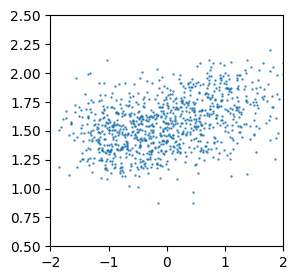

0.386061491397675


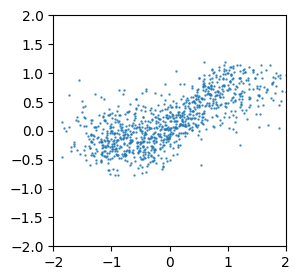

0.6876173029421


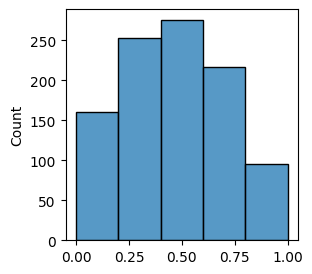

In [18]:
nb_recommend_items = 4
n_test = 1000

############################threshold에 가까운 문항
recommend_items_list = []
diff_list = []
disc_list = []
mrs_list = []
for user in target_user[:n_test]:
  # user = '458_50950208'
  df_user = df[df.uid==user].sort_values('est_challenging')
  #display(df_user)
  ##########################################
  recommend_items = df_user.iid[:nb_recommend_items]
  recommend_items_list.append(recommend_items)
  ##########################################
  diff_list.append(irt[irt.Item_ID.isin(recommend_items)].diffi.mean())
  disc_list.append(irt[irt.Item_ID.isin(recommend_items)].disc.mean())
  mrs = df_user.r_ui[:nb_recommend_items].mean()-1
  mrs_list.append(mrs)
  #print('for user', user, 'recommend', recommend_items.tolist(), '________ Real score was', mrs)
print(len(estimates['Ability']), len(mrs_list))

plt.figure(figsize = (3,3))
plt.xlim((-2, 2))
plt.ylim((0.5,2.5))
plt.scatter(estimates['Ability'][:n_test], disc_list, s = 0.5, alpha = 0.8)
plt.show()
corr = np.corrcoef(estimates['Ability'][:n_test], disc_list)
print(corr[0, 1])

plt.figure(figsize = (3,3))
plt.xlim((-2, 2))
plt.ylim((-2,2))
plt.scatter(estimates['Ability'][:n_test], diff_list, s = 0.5, alpha = 0.8)
plt.show()
# 상관계수 출력(능력 & 난이도)
corr = np.corrcoef(estimates['Ability'][:n_test], diff_list)
print(corr[0, 1])

plt.figure(figsize = (3,3))
sns.histplot(x = mrs_list, binwidth= 0.2)
plt.show()



<ipython-input-19-9b56320a5fb2>:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  recommend_items = random.sample(set(df_user.iid), min(nb_recommend_items, len(df_user)))


8065 1000


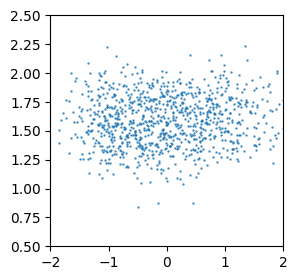

0.05613620599310983


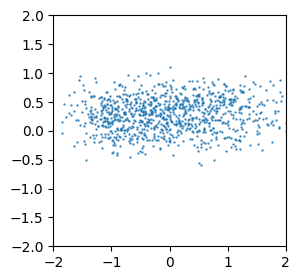

0.08159657478840071


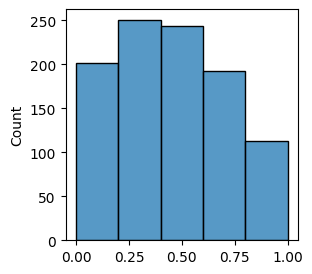

In [19]:
############################ random
recommend_items_list = []
diff_list = []
disc_list = []
mrs_list = []
for user in target_user[:n_test]:
  # user = '458_50950208'
  df_user = df[df.uid==user].sort_values('est_challenging')
  #display(df_user)
  ##########################################
  df_user = df[df.uid==user]
  recommend_items = random.sample(set(df_user.iid), min(nb_recommend_items, len(df_user)))
  recommend_items_list.append(recommend_items)
  ##########################################
  diff_list.append(irt[irt.Item_ID.isin(recommend_items)].diffi.mean())
  disc_list.append(irt[irt.Item_ID.isin(recommend_items)].disc.mean())
  mrs = df_user.r_ui[:nb_recommend_items].mean()-1
  mrs_list.append(mrs)
  #print('for user', user, 'recommend', recommend_items.tolist(), '________ Real score was', mrs)
print(len(estimates['Ability']), len(mrs_list))

plt.figure(figsize = (3,3))
plt.xlim((-2, 2))
plt.ylim((0.5,2.5))
plt.scatter(estimates['Ability'][:n_test], disc_list, s = 0.5, alpha = 0.8)
plt.show()
corr = np.corrcoef(estimates['Ability'][:n_test], disc_list)
print(corr[0, 1])

plt.figure(figsize = (3,3))
plt.xlim((-2, 2))
plt.ylim((-2,2))
plt.scatter(estimates['Ability'][:n_test], diff_list, s = 0.5, alpha = 0.8)
plt.show()
# 상관계수 출력(능력 & 난이도)
corr = np.corrcoef(estimates['Ability'][:n_test], diff_list)
print(corr[0, 1])

plt.figure(figsize = (3,3))
sns.histplot(x = mrs_list, binwidth= 0.2)
plt.show()